In [1]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.stats.stattools import durbin_watson
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
# mpl.rcParams["text.usetex"] = True
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.size"] = "10"

In [3]:
from utils import (
    adf_test,
    kpss_test,
    grangers_causation_matrix,
    adjust,
    cointegration_test,
    splitter,
    create_plot,
    forecast_accuracy
)


### Loading the Dataset

In [4]:
ts_prices_eth = pd.read_csv("Data/Time_Series/prices/ethereum_19_22.csv",index_col='date',parse_dates=['date'])

In [5]:
# crypto = 'crypto_bitcoin'
crypto = 'crypto_ethereum'
# crypto = 'crypto_xrp'

In [6]:
model ='VADER'
df = pd.read_csv(f"Data/Time_Series/{crypto}/{model}_sts_19_22.csv",index_col='posted_on',parse_dates=['posted_on'])

In [7]:
df.columns

Index(['positive_count', 'negative_count', 'neutral_count', 'total_posts',
       'total_words', 'total_stopwords', 'total_comments',
       'average_word_length', 'mean_vader_score'],
      dtype='object')

In [8]:
ts_prices_eth=ts_prices_eth.join(df)

In [9]:
# Remove Neutral Time Series
for c in ts_prices_eth.columns:
    if 'mean' in c.lower() or 'neutral' in c.lower():
        print(f"Dropping column {c}")
        ts_prices_eth.drop(c,axis=1,inplace=True)

Dropping column neutral_count
Dropping column mean_vader_score


In [10]:
ts_prices_eth = ts_prices_eth[ts_prices_eth.index.year == 2022]
ts_prices_eth.index.year.unique()

Int64Index([2022], dtype='int64', name='date')

In [11]:
ts_prices_eth.head(5)

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2022-01-01,3686.40,48,6,150,7882,3286,4182,6.343439
2022-01-02,3780.32,43,9,213,10367,4221,4042,6.353909
2022-01-03,3835.40,65,16,263,13306,5376,3827,6.311037
2022-01-04,3769.40,59,12,242,13281,4489,4250,6.323551
2022-01-05,3794.91,72,25,292,10880,4329,4341,6.227107


In [12]:
df = ts_prices_eth

In [13]:
df.isna().sum()

price                  0
positive_count         0
negative_count         0
total_posts            0
total_words            0
total_stopwords        0
total_comments         0
average_word_length    0
dtype: int64

### VAR Model with only 2022 data

In [14]:
df=ts_prices_eth
# Checking for Stationarity
for i in range(0,len(df.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df.columns[i])
    # plot_acf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df.iloc[:,i])
    kpss_test(df.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is non-stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series 

Since some of the time series are not stationary, we'll have to take first difference

In [15]:
df_first_differenced = df.diff().dropna()

In [16]:
df_first_differenced.head(2)

,price,positive_count,negative_count,total_posts,total_words,total_stopwords,total_comments,average_word_length
date,,,,,,,,
2022-01-02,93.92,-5.0,3.0,63.0,2485.0,935.0,-140.0,0.010469
2022-01-03,55.08,22.0,7.0,50.0,2939.0,1155.0,-215.0,-0.042872


In [17]:
for i in range(0,len(df_first_differenced.columns)):
    # fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True)
    # ax1, ax2 = axes.flatten()
    print('Series:', df_first_differenced.columns[i])
    # plot_acf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Autocorrelation Plot', ax=ax1)
    # plot_pacf(ts_prices_eth.iloc[1:,i], lags=60, zero=False, alpha=.05, title='Partial Autocorrelation Plot', ax=ax2)
    # plt.show()
    adf_test(df_first_differenced.iloc[:,i])
    kpss_test(df_first_differenced.iloc[:,i])
    print("*"*100)

Series: price
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: positive_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: negative_count
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is stationary
****************************************************************************************************
Series: total_posts
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS Test
	Result: The series is non-stationary
****************************************************************************************************
Series: total_words
Augmented Dicky Fuller Test
	Result: The series is stationary
KPSS T

In [18]:
gc_res = grangers_causation_matrix(df_first_differenced, variables = df_first_differenced.columns, maxlag=40)    

In [19]:
def negative_grey(val):
    color = 'grey' if val < 0.05 else ''
    return 'background-color:' + color  

def negative_bold(val):
    bold = 'bold' if val < 0.05 else ''
    return 'font-weight: %s' % bold

gc_res.style.applymap(negative_grey).applymap(negative_bold)

,price_x,positive_count_x,negative_count_x,total_posts_x,total_words_x,total_stopwords_x,total_comments_x,average_word_length_x
price_y,1.000000,0.552500,0.000000,0.087900,0.028200,0.021400,0.000700,0.434700
positive_count_y,0.090900,1.000000,0.257400,0.049900,0.000100,0.000000,0.592300,0.229100
negative_count_y,0.014800,0.152800,1.000000,0.002000,0.000900,0.000500,0.000000,0.000000
total_posts_y,0.121300,0.000000,0.392700,1.000000,0.033900,0.003800,0.002600,0.254200
total_words_y,0.290100,0.002100,0.014100,0.076300,1.000000,0.092600,0.005600,0.097500
total_stopwords_y,0.114000,0.053500,0.014100,0.078300,0.084700,1.000000,0.016200,0.106000
total_comments_y,0.021800,0.493100,0.000000,0.332000,0.051600,0.064500,1.000000,0.038700
average_word_length_y,0.067200,0.033700,0.000000,0.000100,0.143600,0.067400,0.000300,1.000000


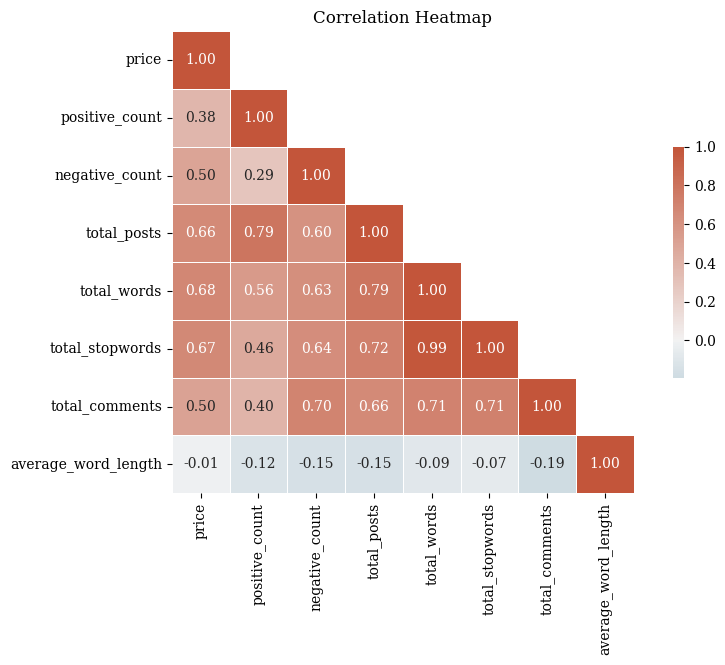

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

correlation_matrix = df.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool),k=1)

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, vmax=1, center=0, annot=True, fmt=".2f",
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Add title
plt.title('Correlation Heatmap')

# Show the heatmap
plt.show()

In [22]:
df_first_differenced = df_first_differenced[['price', 'positive_count','negative_count', 'total_posts',
       'total_words','total_comments']]

In [23]:
cointegration_test(df_first_differenced)

Name                           ::  Test Stat > C(95%)    =>  Signif 
 ----------------------------------------------------------------------
price                          ::  714.13    > 83.9383   =>   True
positive_count                 ::  543.24    > 60.0627   =>   True
negative_count                 ::  390.62    > 40.1749   =>   True
total_posts                    ::  265.68    > 24.2761   =>   True
total_words                    ::  154.73    > 12.3212   =>   True
total_comments                 ::  51.15     > 4.1296    =>   True


In [24]:
train_df, test_df = splitter(df_first_differenced)
nobs = len(test_df)

In [25]:
train_df.index[0],train_df.index[-1], len(train_df)

(Timestamp('2022-01-02 00:00:00'), Timestamp('2022-10-19 00:00:00'), 291)

In [26]:
test_df.index[0],test_df.index[-1],len(test_df)

(Timestamp('2022-10-20 00:00:00'), Timestamp('2022-12-31 00:00:00'), 73)

In [28]:
model = VAR(train_df)
x = model.select_order(maxlags=21)
x.summary()

,AIC,BIC,FPE,HQIC
0,50.90,50.98,1.281e+22,50.94
1,49.91,50.47*,4.722e+21,50.13
2,49.68,50.72,3.764e+21,50.10*
3,49.56,51.08,3.356e+21,50.17
4,49.52*,51.52,3.229e+21*,50.33
5,49.57,52.05,3.395e+21,50.57
6,49.65,52.61,3.684e+21,50.84
7,49.66,53.10,3.746e+21,51.04
8,49.74,53.66,4.089e+21,51.31
9,49.76,54.16,4.212e+21,51.52


In [29]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 24, Jun, 2024
Time:                     14:12:26
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    51.6764
Nobs:                     287.000    HQIC:                   50.5303
Log likelihood:          -9434.52    FPE:                4.10484e+21
AIC:                      49.7638    Det(Omega_mle):     2.48691e+21
--------------------------------------------------------------------
Results for equation price
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                    -8.033866         5.495314           -1.462           0.144
L1.price                  0.069133         0.062003            1.115           0.265
L1.positive_count         0.401093         0

In [30]:
irf = model_fitted.irf(periods=8)

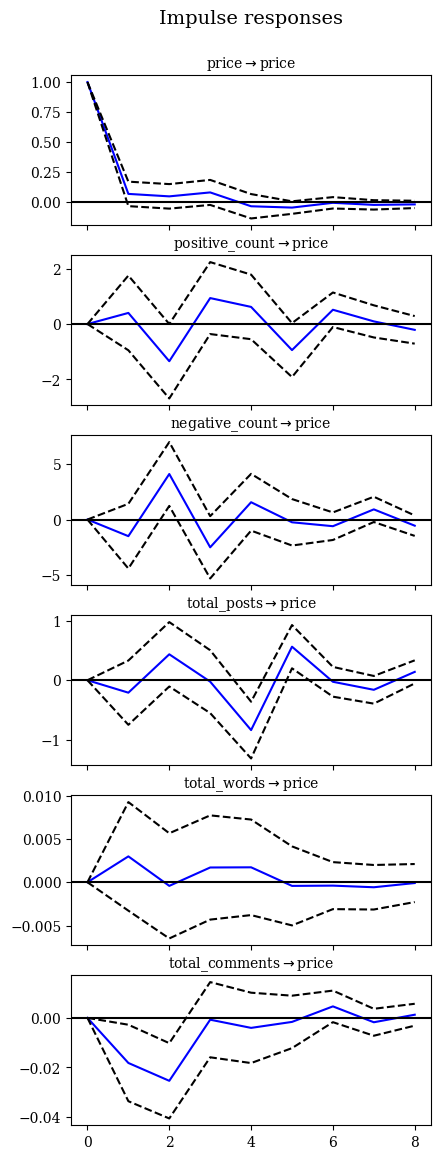

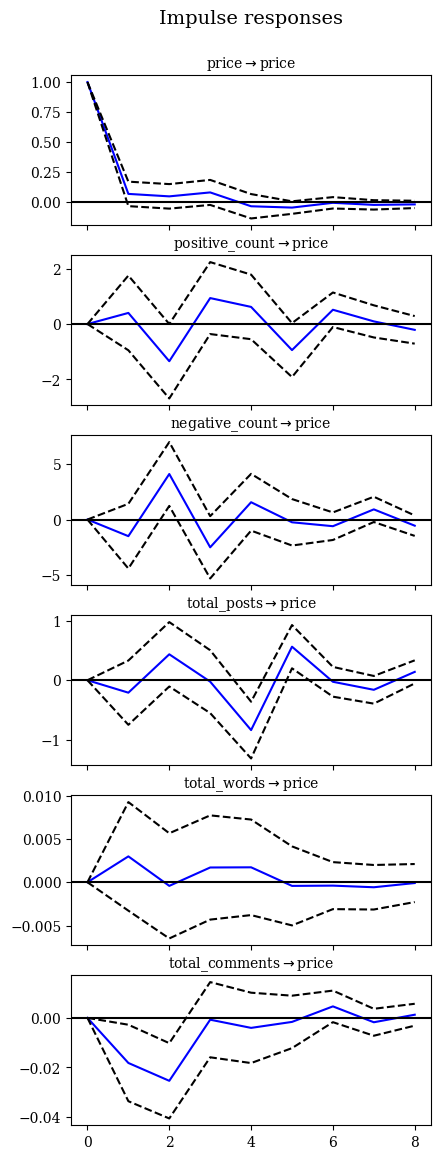

In [48]:
irf.plot(orth=False, 
        response='price',
        signif=0.10,
        figsize=(4, 12),
        subplot_params={'fontsize': 10})

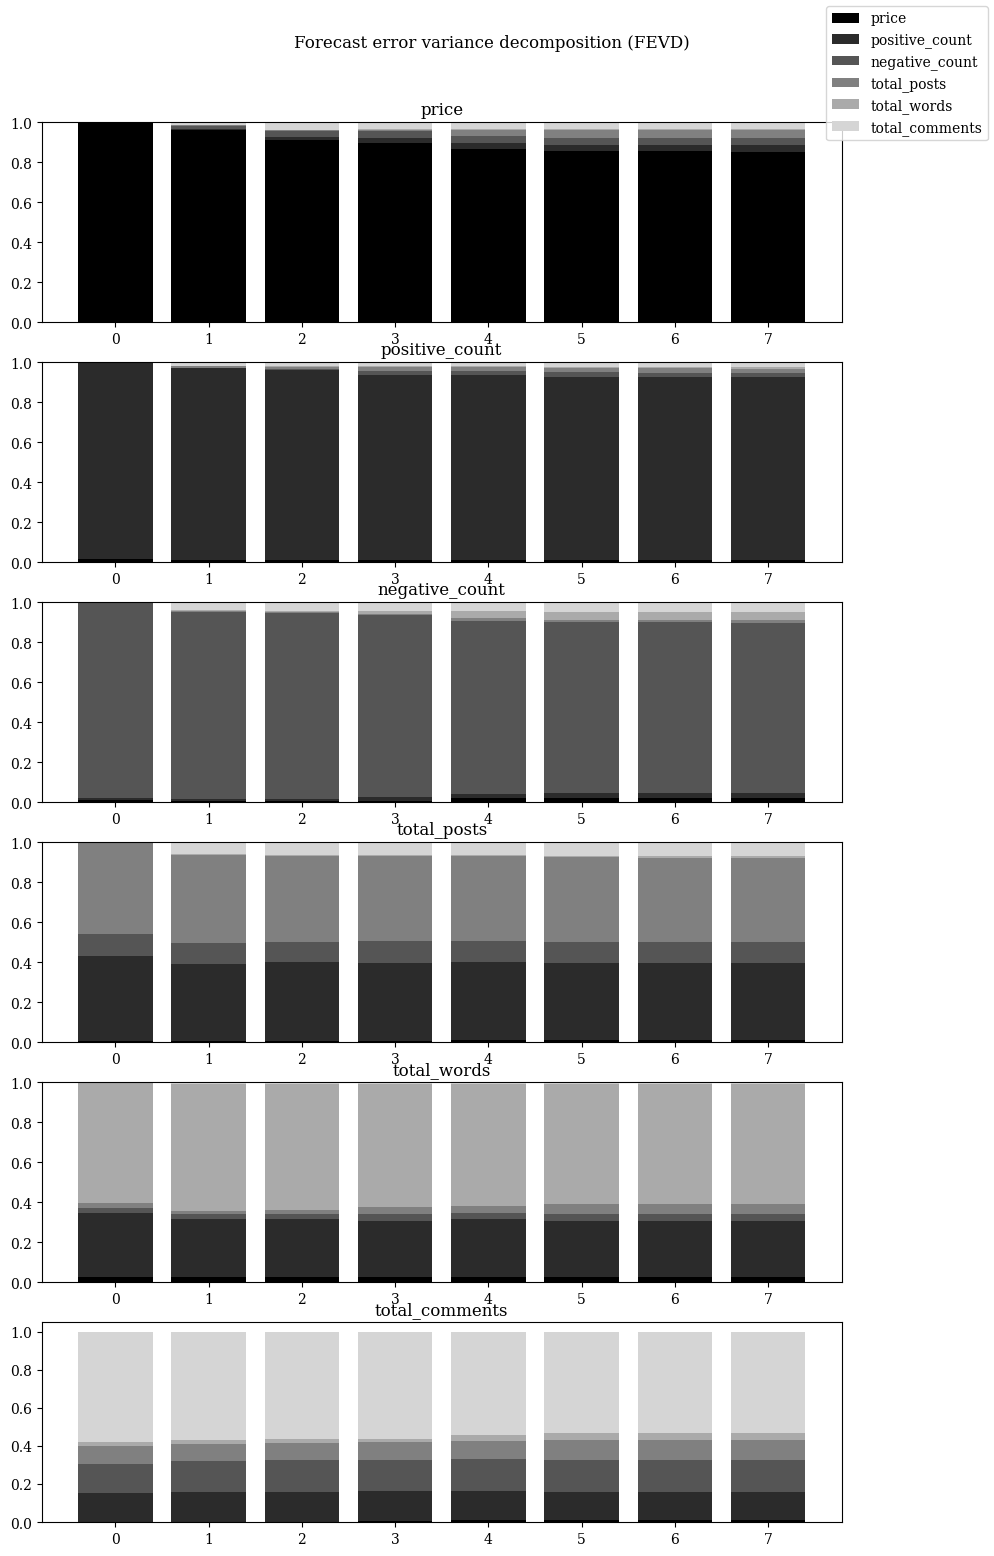

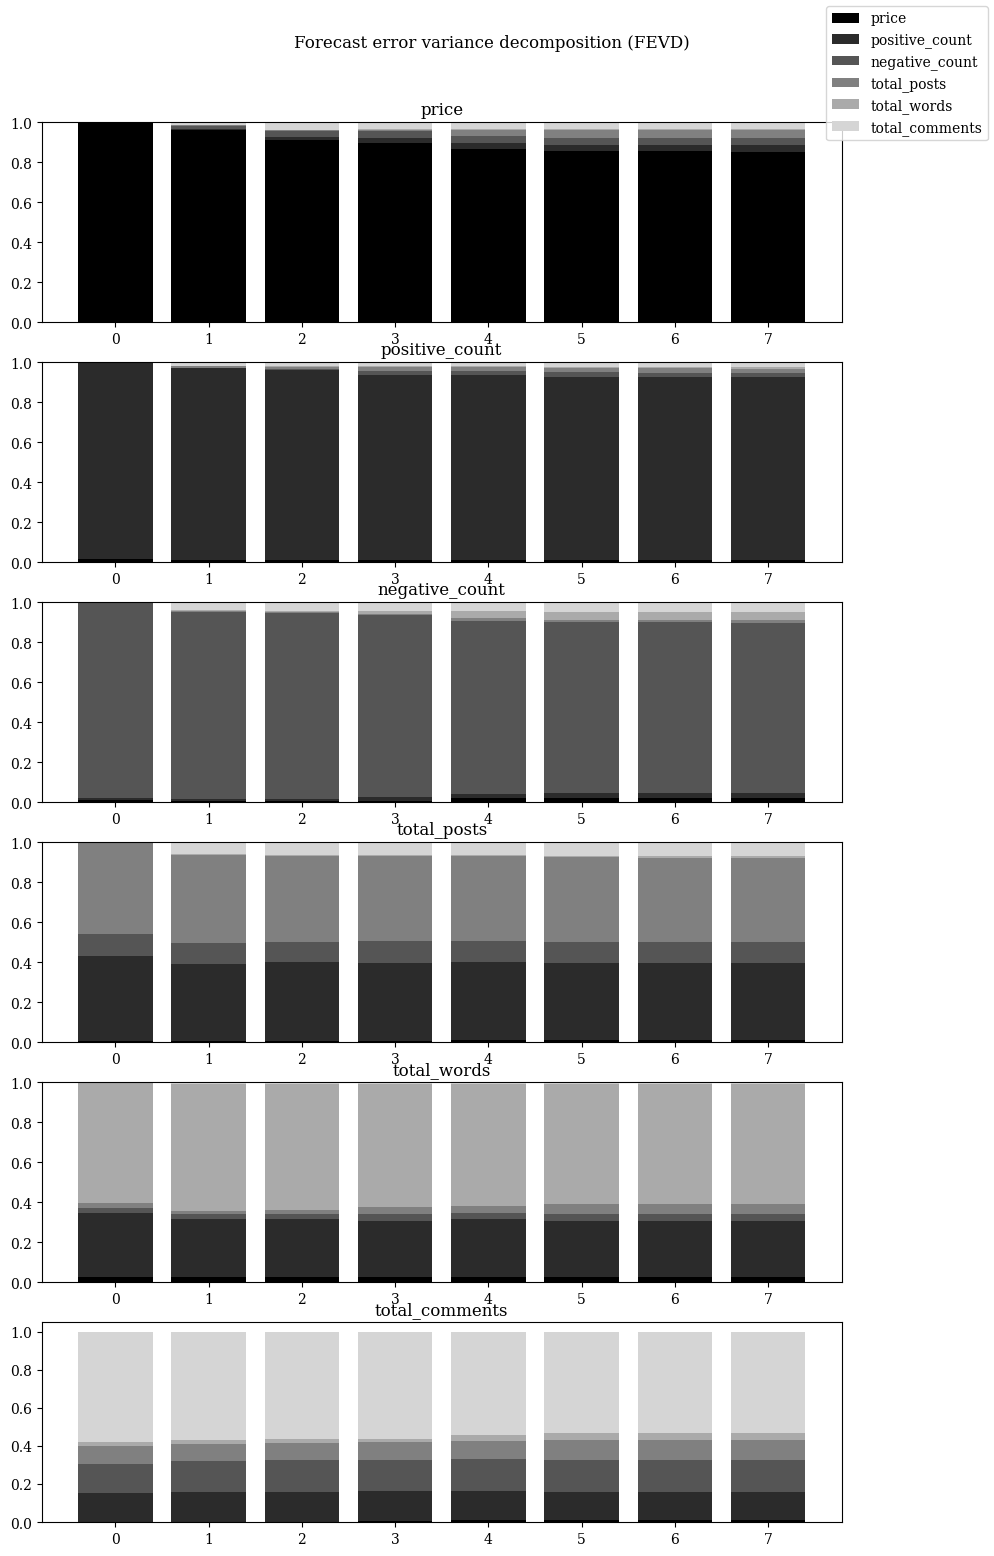

In [32]:
fevd = model_fitted.fevd(8)
fevd.plot(figsize=(10, 16))
# plt.xticks(fontsize=5)
# plt.yticks(fontsize=5)
# plt.show()

In [33]:
# Input data for forecasting
lag_order=model_fitted.k_ar
forecast_input = train_df.values[-lag_order:]
forecast_input

array([[-2.194e+01, -3.000e+00, -1.000e+00, -1.000e+00,  1.062e+03,
         7.200e+01],
       [ 3.125e+01,  8.000e+00,  1.000e+00,  9.000e+00,  1.910e+03,
         1.420e+02],
       [ 2.650e+01, -1.000e+00, -2.000e+00,  1.300e+01, -1.250e+03,
        -2.000e+02],
       [-2.163e+01,  3.000e+00,  2.000e+00, -1.300e+01, -1.290e+02,
         2.090e+02]])

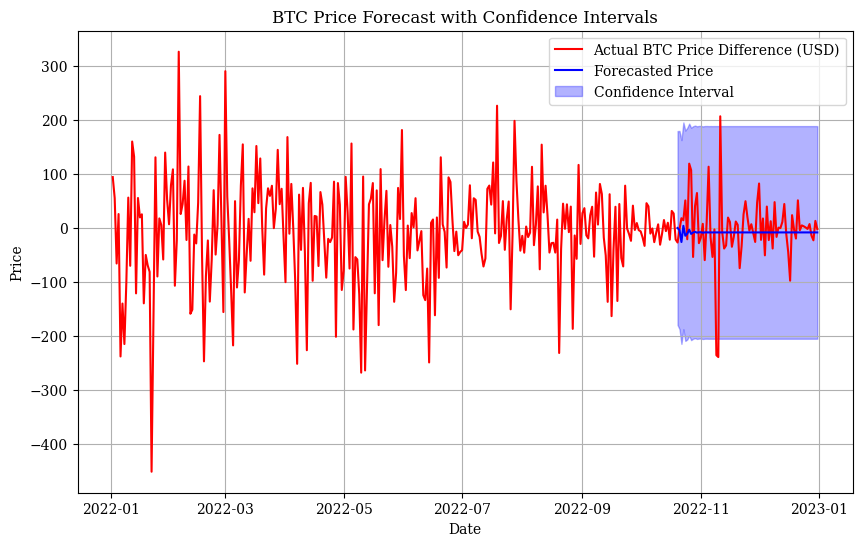

In [34]:
forecast_steps = 73
forecast_result = model_fitted.forecast_interval(forecast_input, steps=forecast_steps)

# Extract the forecast and confidence intervals
forecast_values = forecast_result[0]
lower_bound = forecast_result[1]
upper_bound = forecast_result[2]

# Extract the 'price' variable forecast
price_forecast = forecast_values[:, 0]
price_lower = lower_bound[:, 0]
price_upper = upper_bound[:, 0]

# Create a date range for the forecast
# forecast_dates = pd.date_range(start=df.index[-1], periods=forecast_steps+1, closed='right')

# # Plot the results
plt.figure(figsize=(10, 6))
plt.plot(df_first_differenced.index, df_first_differenced['price'], label='Actual BTC Price Difference (USD)',color='red')
plt.plot(test_df.index, price_forecast, label='Forecasted Price', color='blue')
plt.fill_between(test_df.index, price_lower, price_upper, color='blue', alpha=0.3, label='Confidence Interval')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BTC Price Forecast with Confidence Intervals')
plt.legend()
plt.grid()
plt.show()

In [35]:
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_first_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

price  : 2.0
positive_count : 2.05
negative_count : 2.09
total_posts : 2.07
total_words : 2.07
total_comments : 2.04


In [38]:
fc = model_fitted.forecast(y=forecast_input, steps=nobs)

In [39]:
forecast = pd.DataFrame(model_fitted.forecast(y= forecast_input, steps=nobs), index = test_df.index,columns = test_df.columns)

In [40]:
forecast.iloc[0]

price              -0.299087
positive_count     -4.724686
negative_count     -0.549517
total_posts        -0.743691
total_words      -472.179943
total_comments   -246.142326
Name: 2022-10-20 00:00:00, dtype: float64

In [41]:
df_first_differenced.iloc[290]

price             -21.63
positive_count      3.00
negative_count      2.00
total_posts       -13.00
total_words      -129.00
total_comments    209.00
Name: 2022-10-19 00:00:00, dtype: float64

In [42]:
df_first_differenced.columns

Index(['price', 'positive_count', 'negative_count', 'total_posts',
       'total_words', 'total_comments'],
      dtype='object')

In [43]:
row = df.iloc[[0]][['price','positive_count', 'negative_count', 'total_posts', 'total_words', 'total_comments']]
row

,price,positive_count,negative_count,total_posts,total_words,total_comments
date,,,,,,
2022-01-01,3686.4,48,6,150,7882,4182


In [44]:
# Invert Transformation
df_result = pd.concat([df_first_differenced.iloc[:291],forecast]) 
df_result = pd.concat([row,df_result]).cumsum()

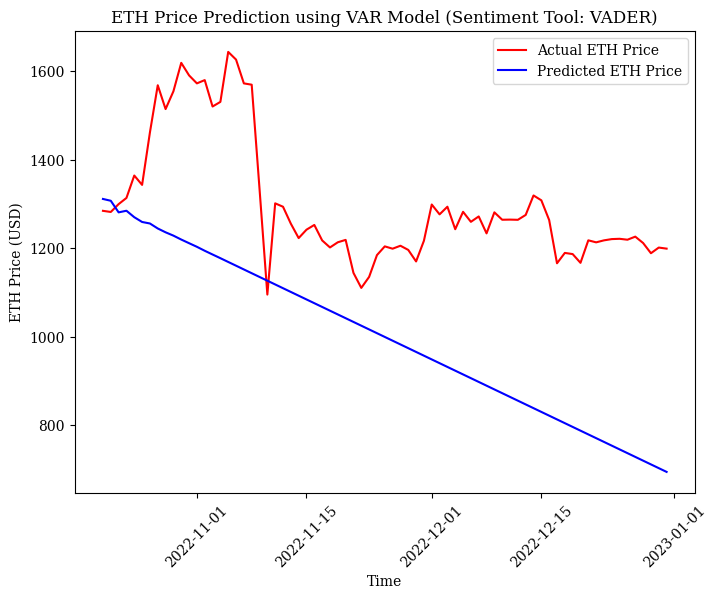

In [45]:
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(ts_prices_eth['price'].iloc[-nobs:], color = 'red', label = 'Actual ETH Price')
plt.plot(df_result['price'].iloc[-nobs:], color = 'blue', label = 'Predicted ETH Price')
plt.title('ETH Price Prediction using VAR Model (Sentiment Tool: VADER)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.ylabel('ETH Price (USD)')
plt.legend()
plt.show()

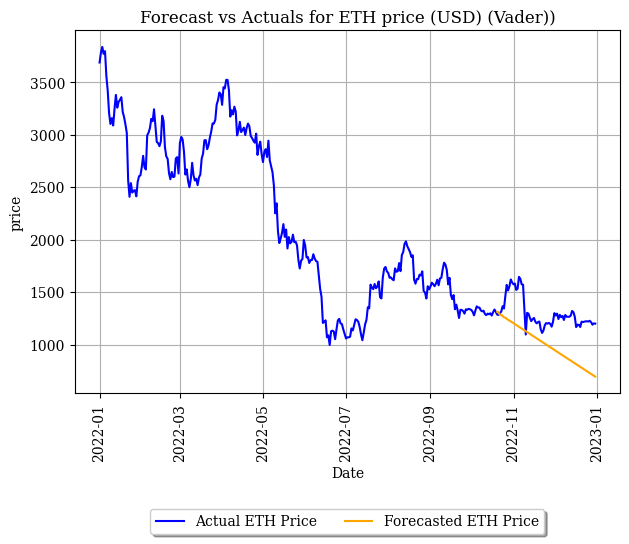

In [46]:
data_predicted = df_result['price'][-nobs:]
data_actual = df['price']
create_plot(data_predicted, data_actual, 'ETH', 'Vader')

In [47]:
print('Forecast Accuracy of: ETH Price')
# accuracy_prod = 
res = forecast_accuracy(data_predicted.values, data_actual[-nobs:],['ETH_ModelA'])
res

Forecast Accuracy of: ETH Price


,MAE,MAPE,MSE,RMSE
ETH_ModelA,302.521555,23.272235,112139.383165,334.872189
